# Transcriptome (scRNA-seq data) + HVG selection

We show an example of scRNA-seq data produced by 10X Chromium. We are using scRNA-seq data `3k PBMCs from a Healthy Donor` (2,700 cells and 32,738 genes) from [10X Genomics Datasets](https://www.10xgenomics.com/resources/datasets). 

This analysis follow [Preprocessing and clustering 3k PBMCs](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) in Scanpy tutorials except for RECODE processing. 

We use [scanpy](https://scanpy.readthedocs.io/en/stable/) to read/write 10X data. Import numpy and scanpy in addlition to screcode.

In [1]:
import screcode
import numpy as np
import scanpy as sc
import pandas as pd
import warnings
warnings.simplefilter('ignore')

Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/) object. 

In [2]:
adata = sc.read_10x_mtx(
    "data/pbmc3k_filtered_gene_bc_matrices/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)
adata.var_names_make_unique()
adata.layers["Raw"] = np.array(adata.X.toarray(),dtype=int)
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'
    layers: 'Raw'

## Preprocessing

In [3]:
# sc.pl.highest_expr_genes(adata, n_top=20)

In [4]:
# sc.pp.filter_cells(adata, min_genes=200)
# sc.pp.filter_genes(adata, min_cells=3)

In [5]:
# # annotate the group of mitochondrial genes as "mt"
# adata.var["mt"] = adata.var_names.str.startswith("MT-")
# sc.pp.calculate_qc_metrics(
#     adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
# )

In [6]:
# sc.pl.violin(
#     adata,
#     ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
#     jitter=0.4,
#     multi_panel=True,
# )

In [7]:
# sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
# sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [8]:
# adata = adata[adata.obs.n_genes_by_counts < 2500, :]
# adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

## Apply RECODE
Apply RECODE to the count matrix. The **anndata** or **ndarray** data format is available. 

In [ ]:
recode = screcode.RECODE()
adata = recode.fit_transform(adata)

start RECODE for scRNA-seq data


### Performance check

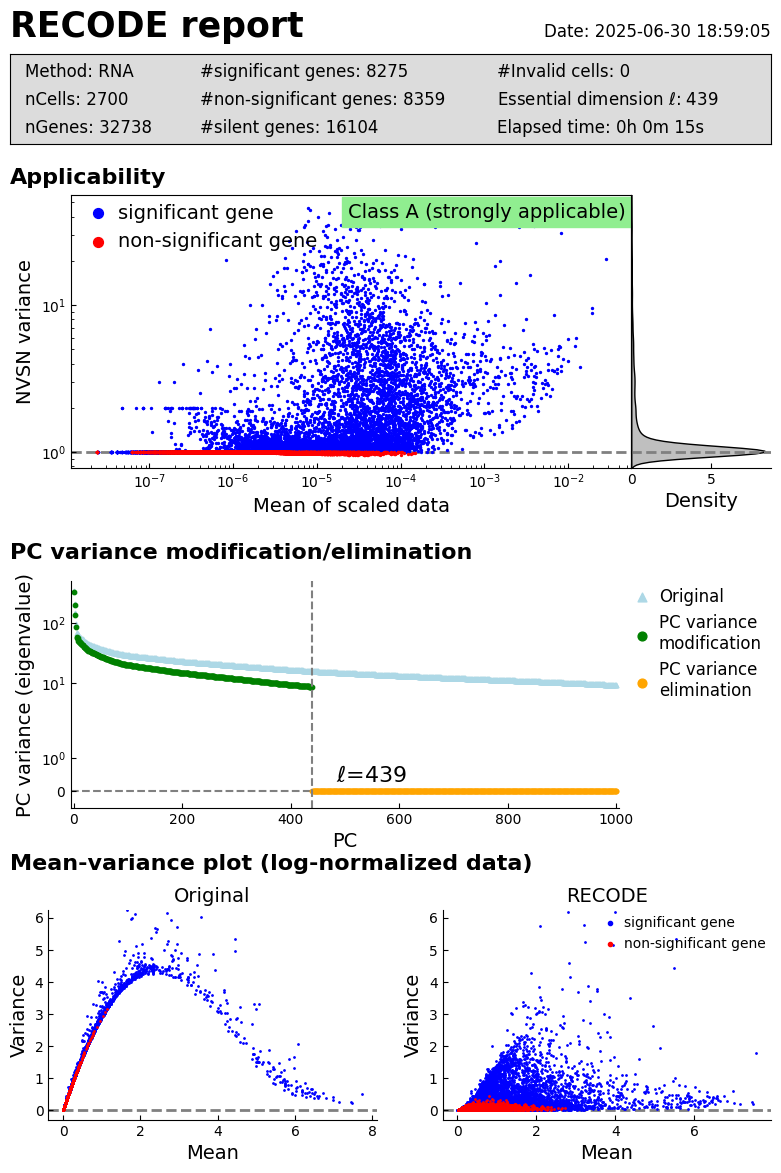

In [ ]:
recode.report()

## Highly variable gene selection using RECODE

In [ ]:
recode.highly_variable_genes(adata)
adata

Highly variable genes are stored in adata.var['RECODE_highly_variable']


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids', 'RECODE_noise_variance', 'RECODE_NVSN_variance', 'RECODE_significance', 'RECODE_denoised_variance', 'RECODE_means', 'RECODE_highly_variable'
    uns: 'RECODE_essential'
    layers: 'Raw', 'RECODE', 'RECODE_NVSN', 'RECODE_norm', 'RECODE_log'

In [ ]:
## Compare with other methods
n_top_genes = 2000

flavor = 'seurat'
target_sum = 1e4
adata_ = adata.copy()
adata_.X = adata.layers["Raw"]
sc.pp.normalize_total(adata_, target_sum=target_sum)
sc.pp.log1p(adata_)
sc.pp.highly_variable_genes(adata_, flavor=flavor, n_top_genes=n_top_genes)
adata.var[f"{flavor}_means"] = adata_.var["means"]
adata.var[f"{flavor}_dispersions"] = adata_.var["dispersions"]
adata.var[f"{flavor}_dispersions_norm"] = adata_.var["dispersions_norm"]


flavor = 'seurat_v3'
adata_ = adata.copy()
adata_.X = adata.layers["Raw"]
sc.pp.highly_variable_genes(adata_, flavor=flavor, n_top_genes=n_top_genes)
adata.var[f"{flavor}_variances"] = adata_.var["variances"]
adata.var[f"{flavor}_variances_norm"] = adata_.var["variances_norm"]

marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

adata.var['HVG_rank_Seurat'] = adata.var['seurat_dispersions_norm'].rank(ascending=False, method='min')
adata.var['HVG_rank_Seurat_v3'] = adata.var['seurat_v3_variances_norm'].rank(ascending=False, method='min')
adata.var['HVG_rank_RECODE'] = adata.var['RECODE_denoised_variance'].rank(ascending=False, method='min')
hvg_ranks = adata.var.loc[marker_genes, ['HVG_rank_Seurat', 'HVG_rank_Seurat_v3', 'HVG_rank_RECODE']]
hvg_ranks = hvg_ranks.astype(int)
hvg_ranks


In [ ]:
adata.X = adata.layers["RECODE_log"]
adata = adata[:, adata.var.RECODE_highly_variable]
adata

View of AnnData object with n_obs × n_vars = 2638 × 2000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'RECODE_noise_variance', 'RECODE_NVSN_variance', 'RECODE_significance', 'RECODE_denoised_variance', 'RECODE_means', 'RECODE_highly_variable'
    uns: 'RECODE_essential'
    layers: 'Raw', 'RECODE', 'RECODE_NVSN', 'RECODE_norm', 'RECODE_log'

## Downstream analysis based on [scanpy](https://scanpy.readthedocs.io/en/stable/index.html)

### PCA

In [ ]:
n_comps = 1000
sc.tl.pca(adata, svd_solver='arpack',n_comps=n_comps)

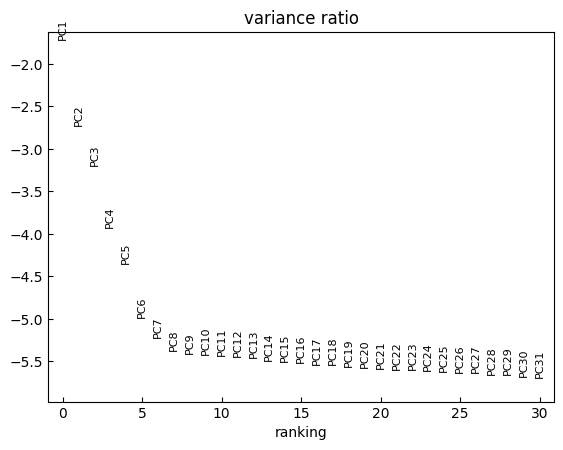

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

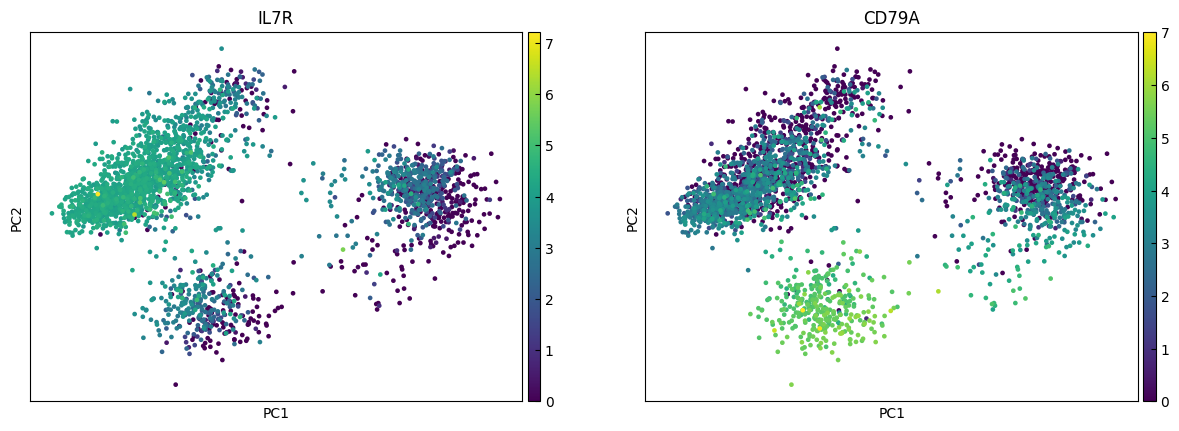

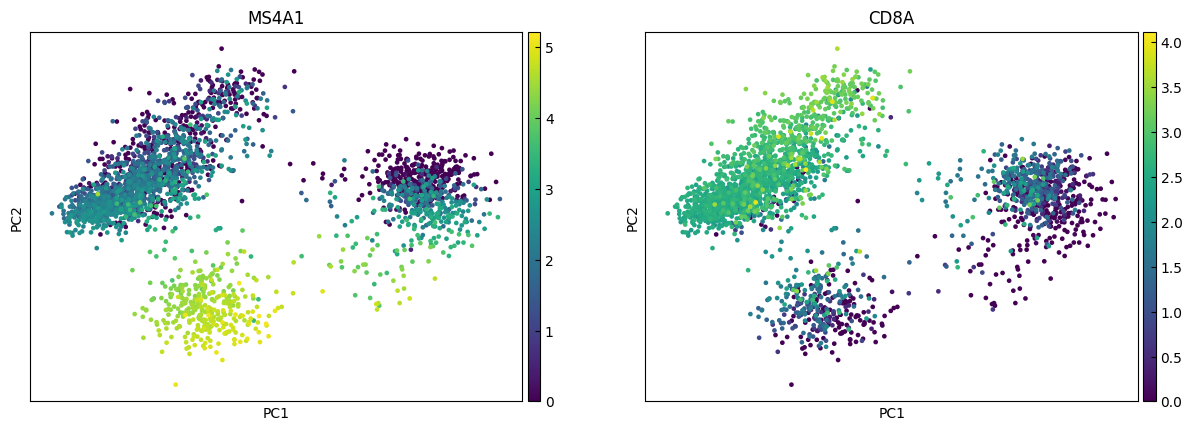

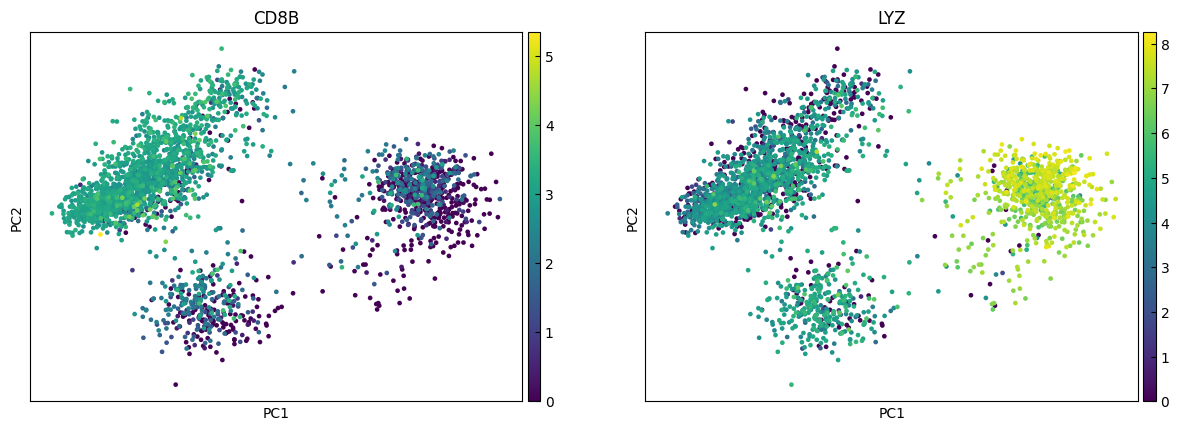

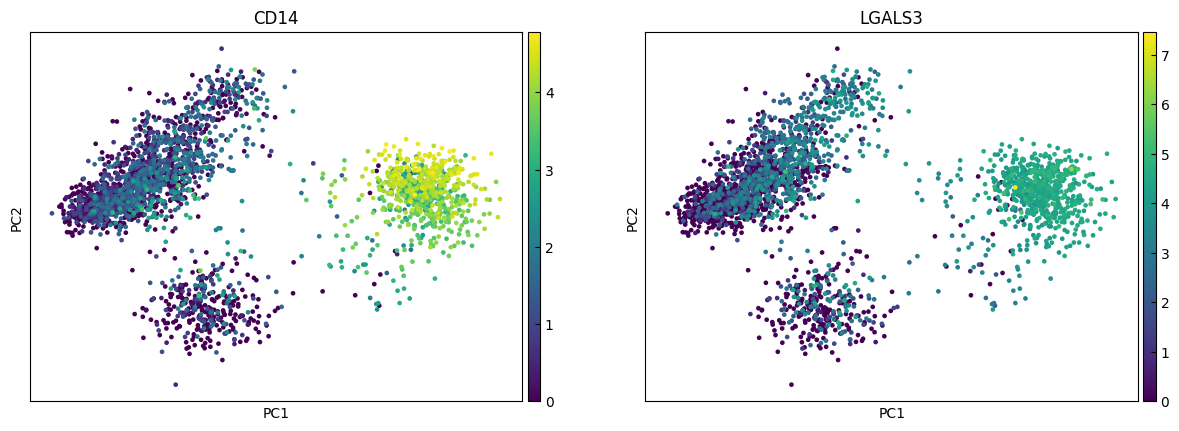

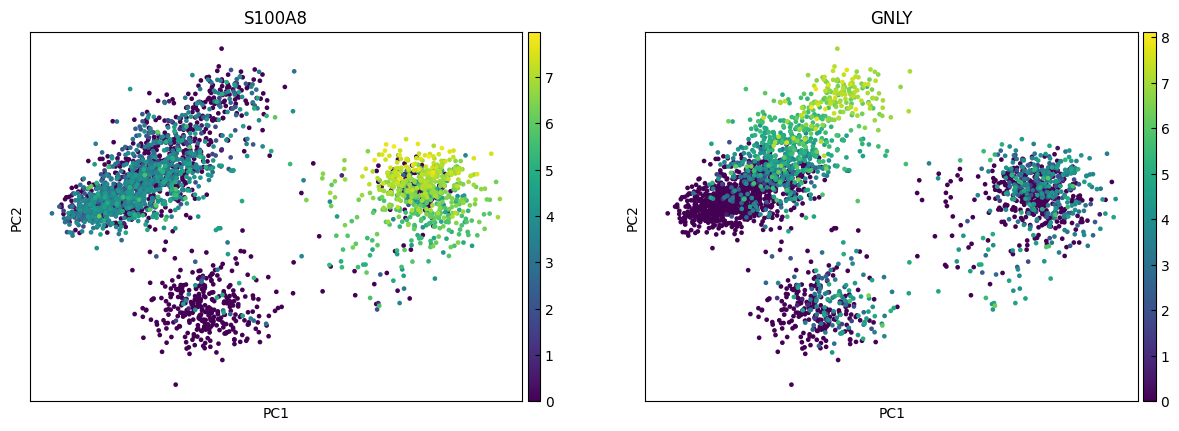

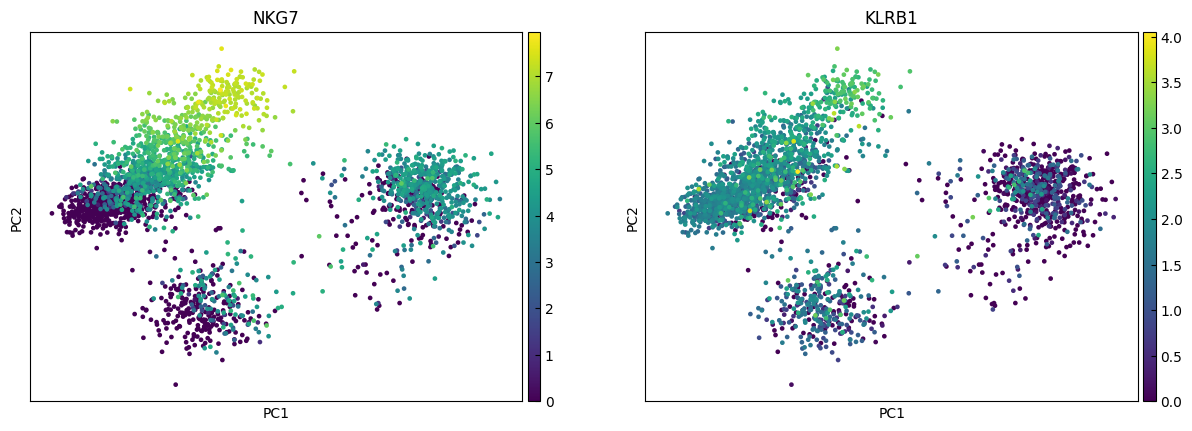

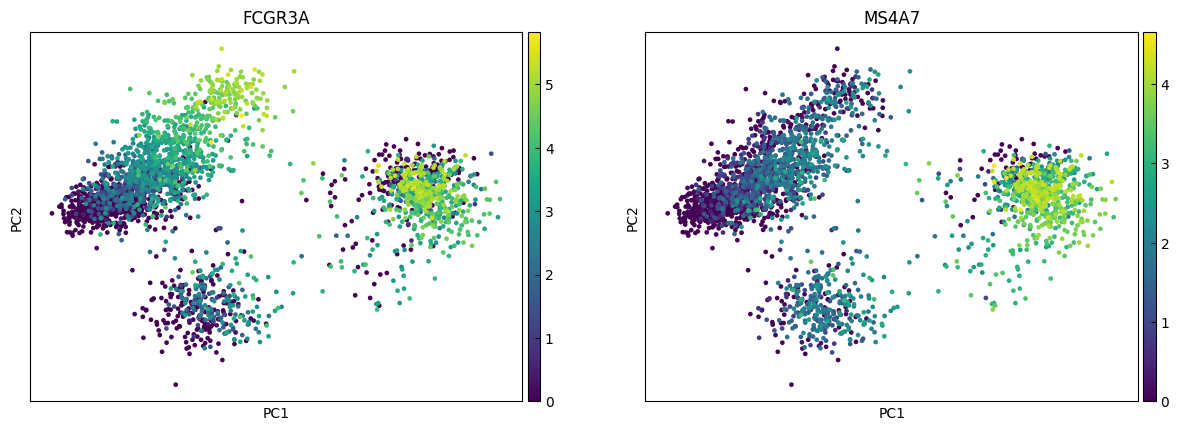

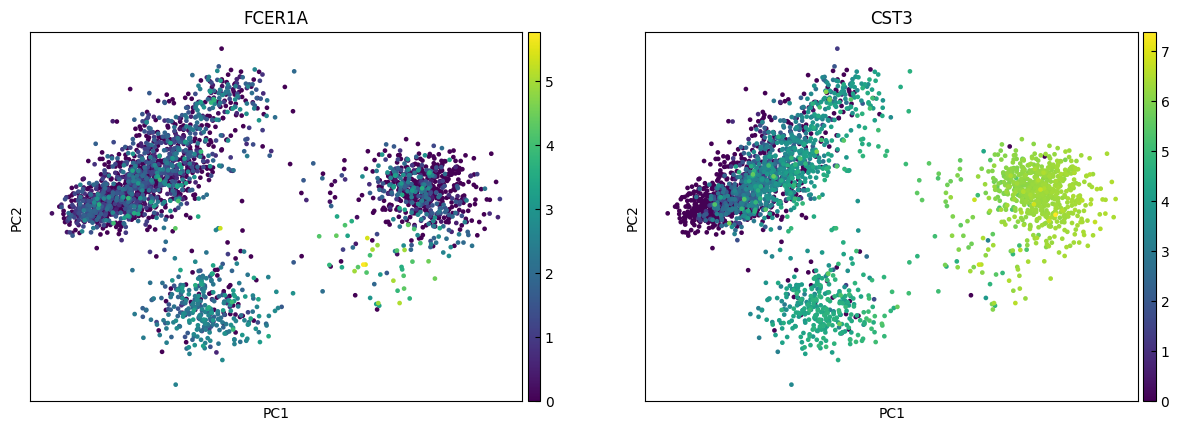

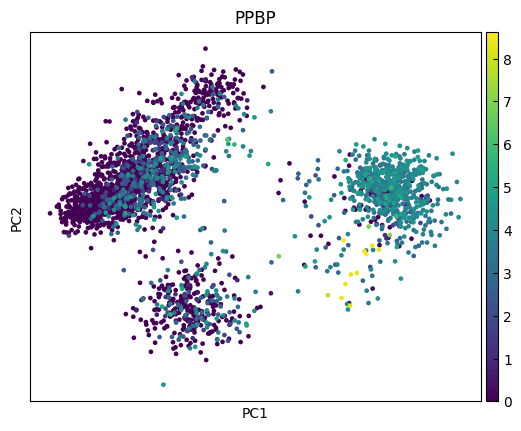

In [ ]:
n_cols = 2
for i in range(0, len(marker_genes),n_cols):
    sc.pl.pca(adata, color=marker_genes[i:i+n_cols])

### UMAP

Note that we do not use the PCA dimentionaly reduction as a preprocessing of UMAP (`n_pca=0`). 

In [ ]:
sc.pp.neighbors(adata, n_pcs=100)
sc.tl.umap(adata)

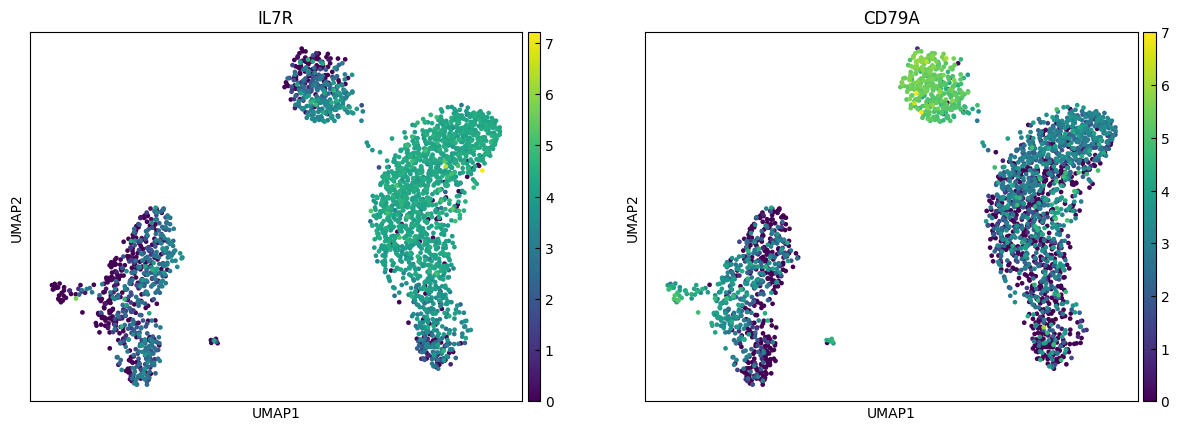

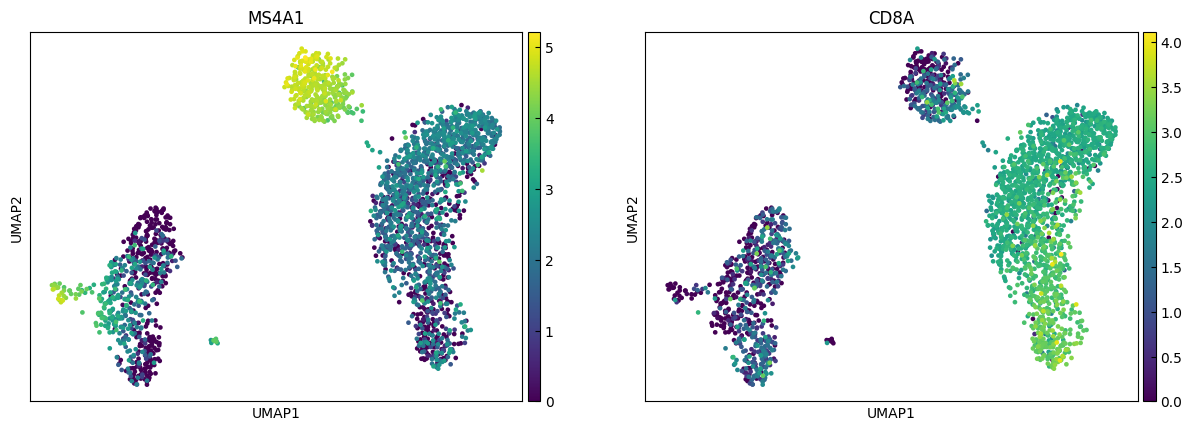

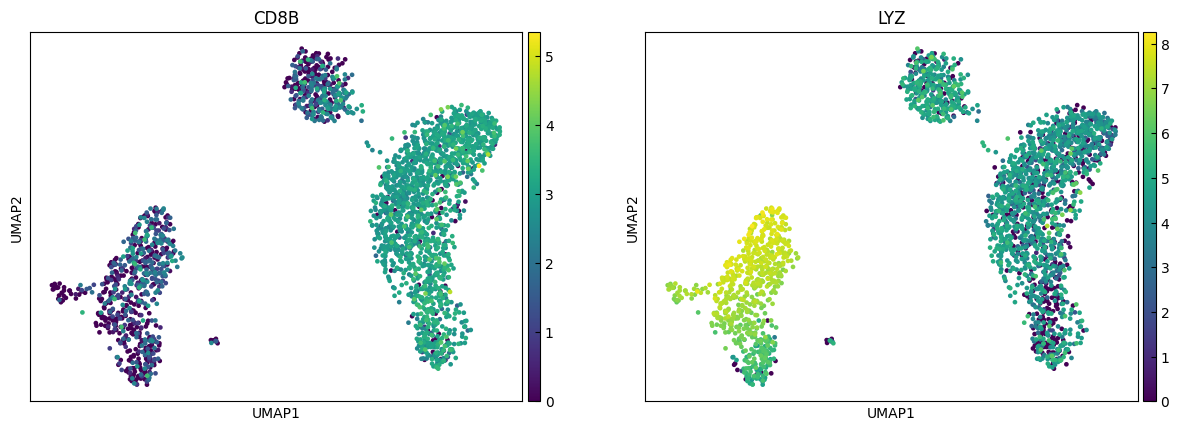

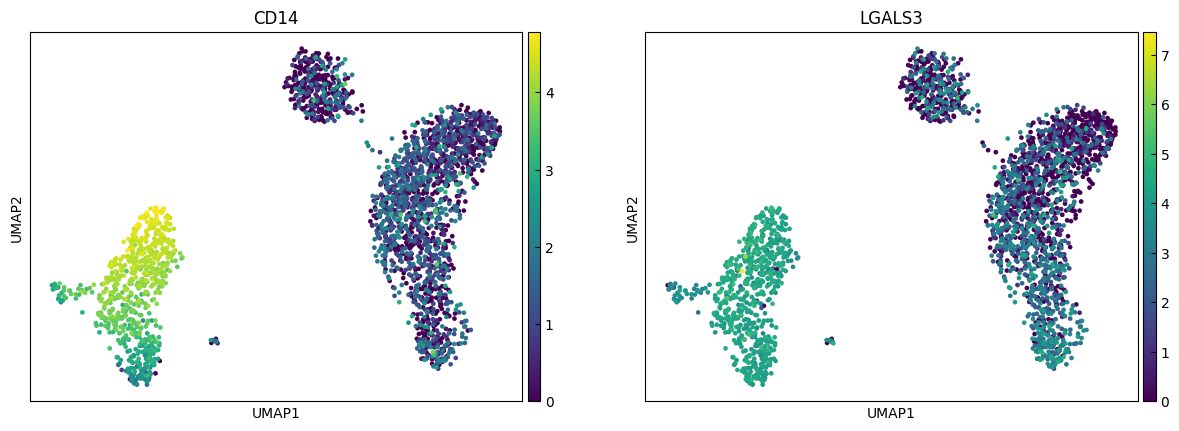

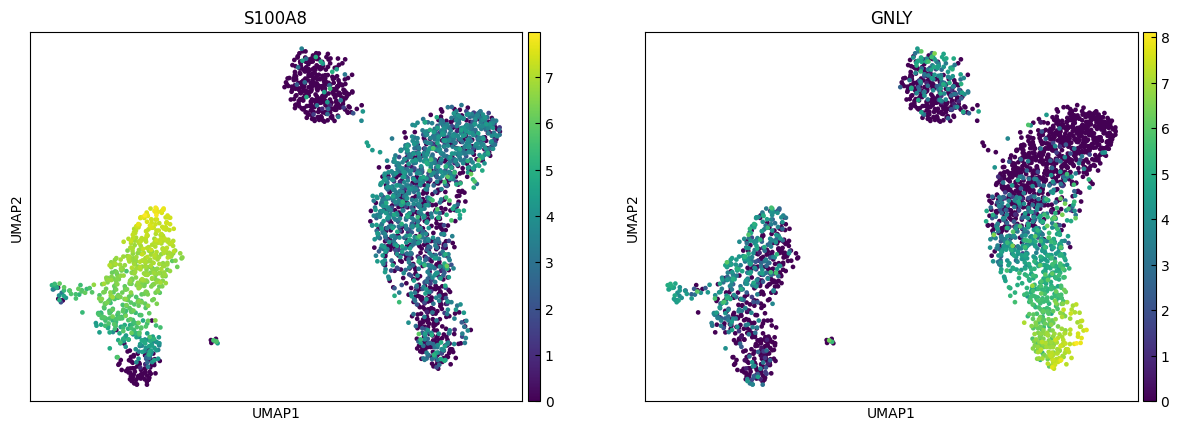

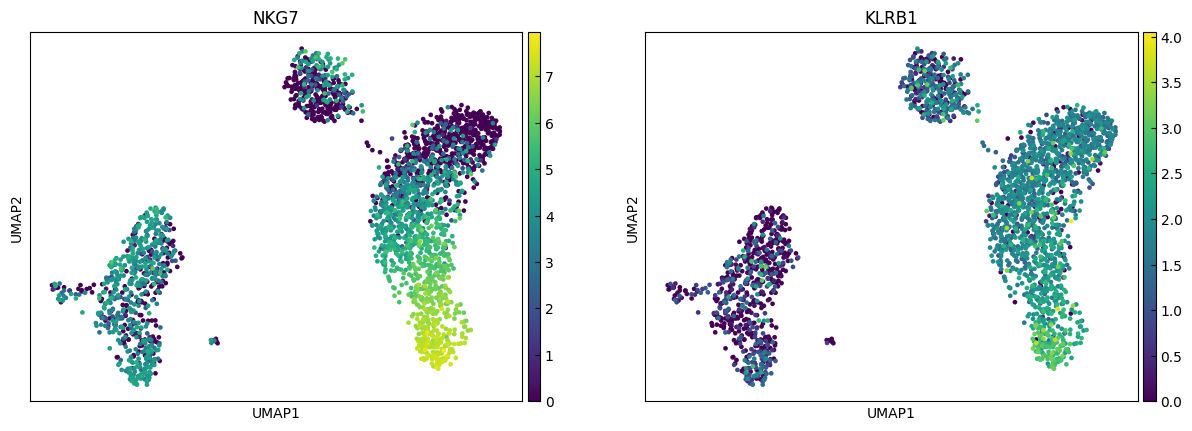

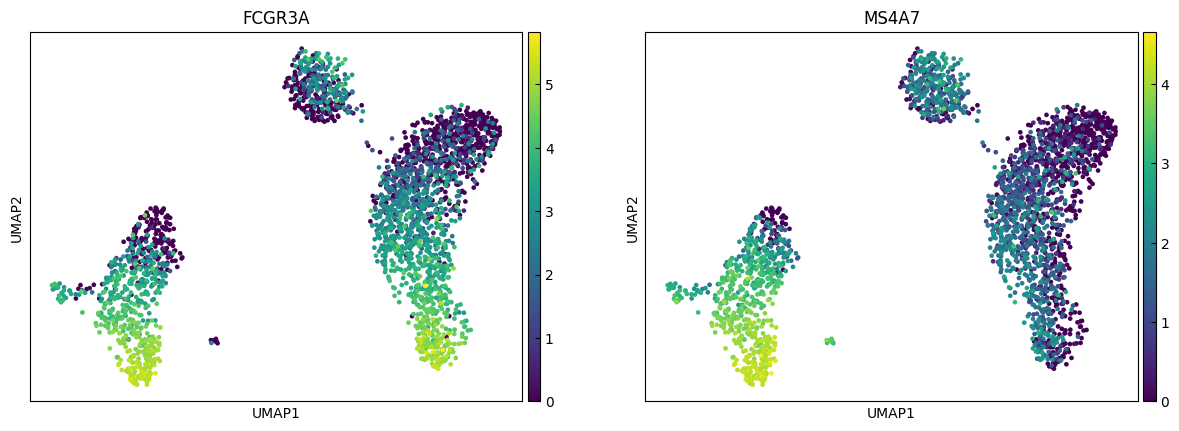

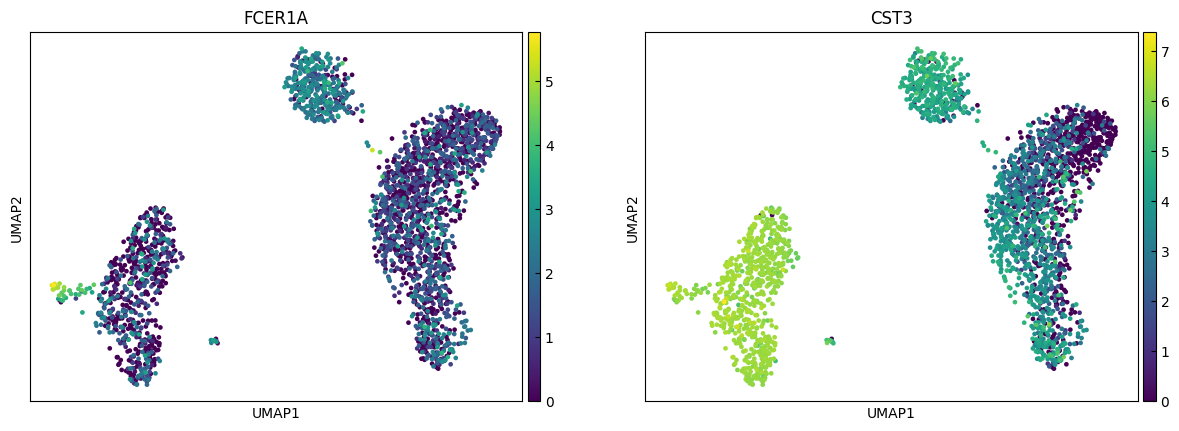

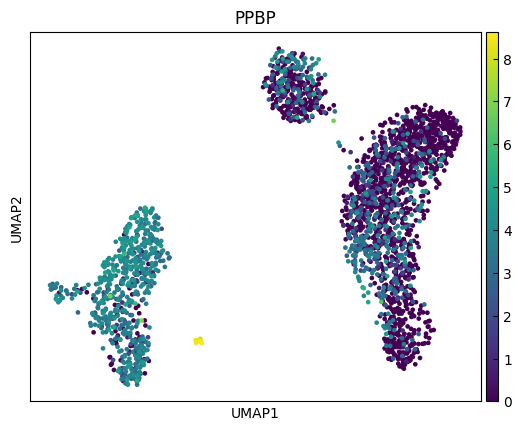

In [ ]:
n_cols = 2
for i in range(0, len(marker_genes),n_cols):
    sc.pl.umap(adata, color=marker_genes[i:i+n_cols])

## Clustering

In [ ]:
# pip install igraph leidenalg

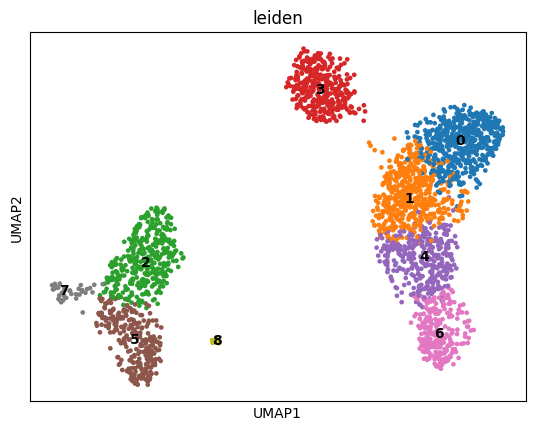

In [ ]:
sc.tl.leiden(adata,resolution=0.9)
if 'leiden_colors' in adata.uns:
    del adata.uns['leiden_colors']
sc.pl.umap(adata, color=['leiden'],legend_loc='on data')

## Finding marker genes

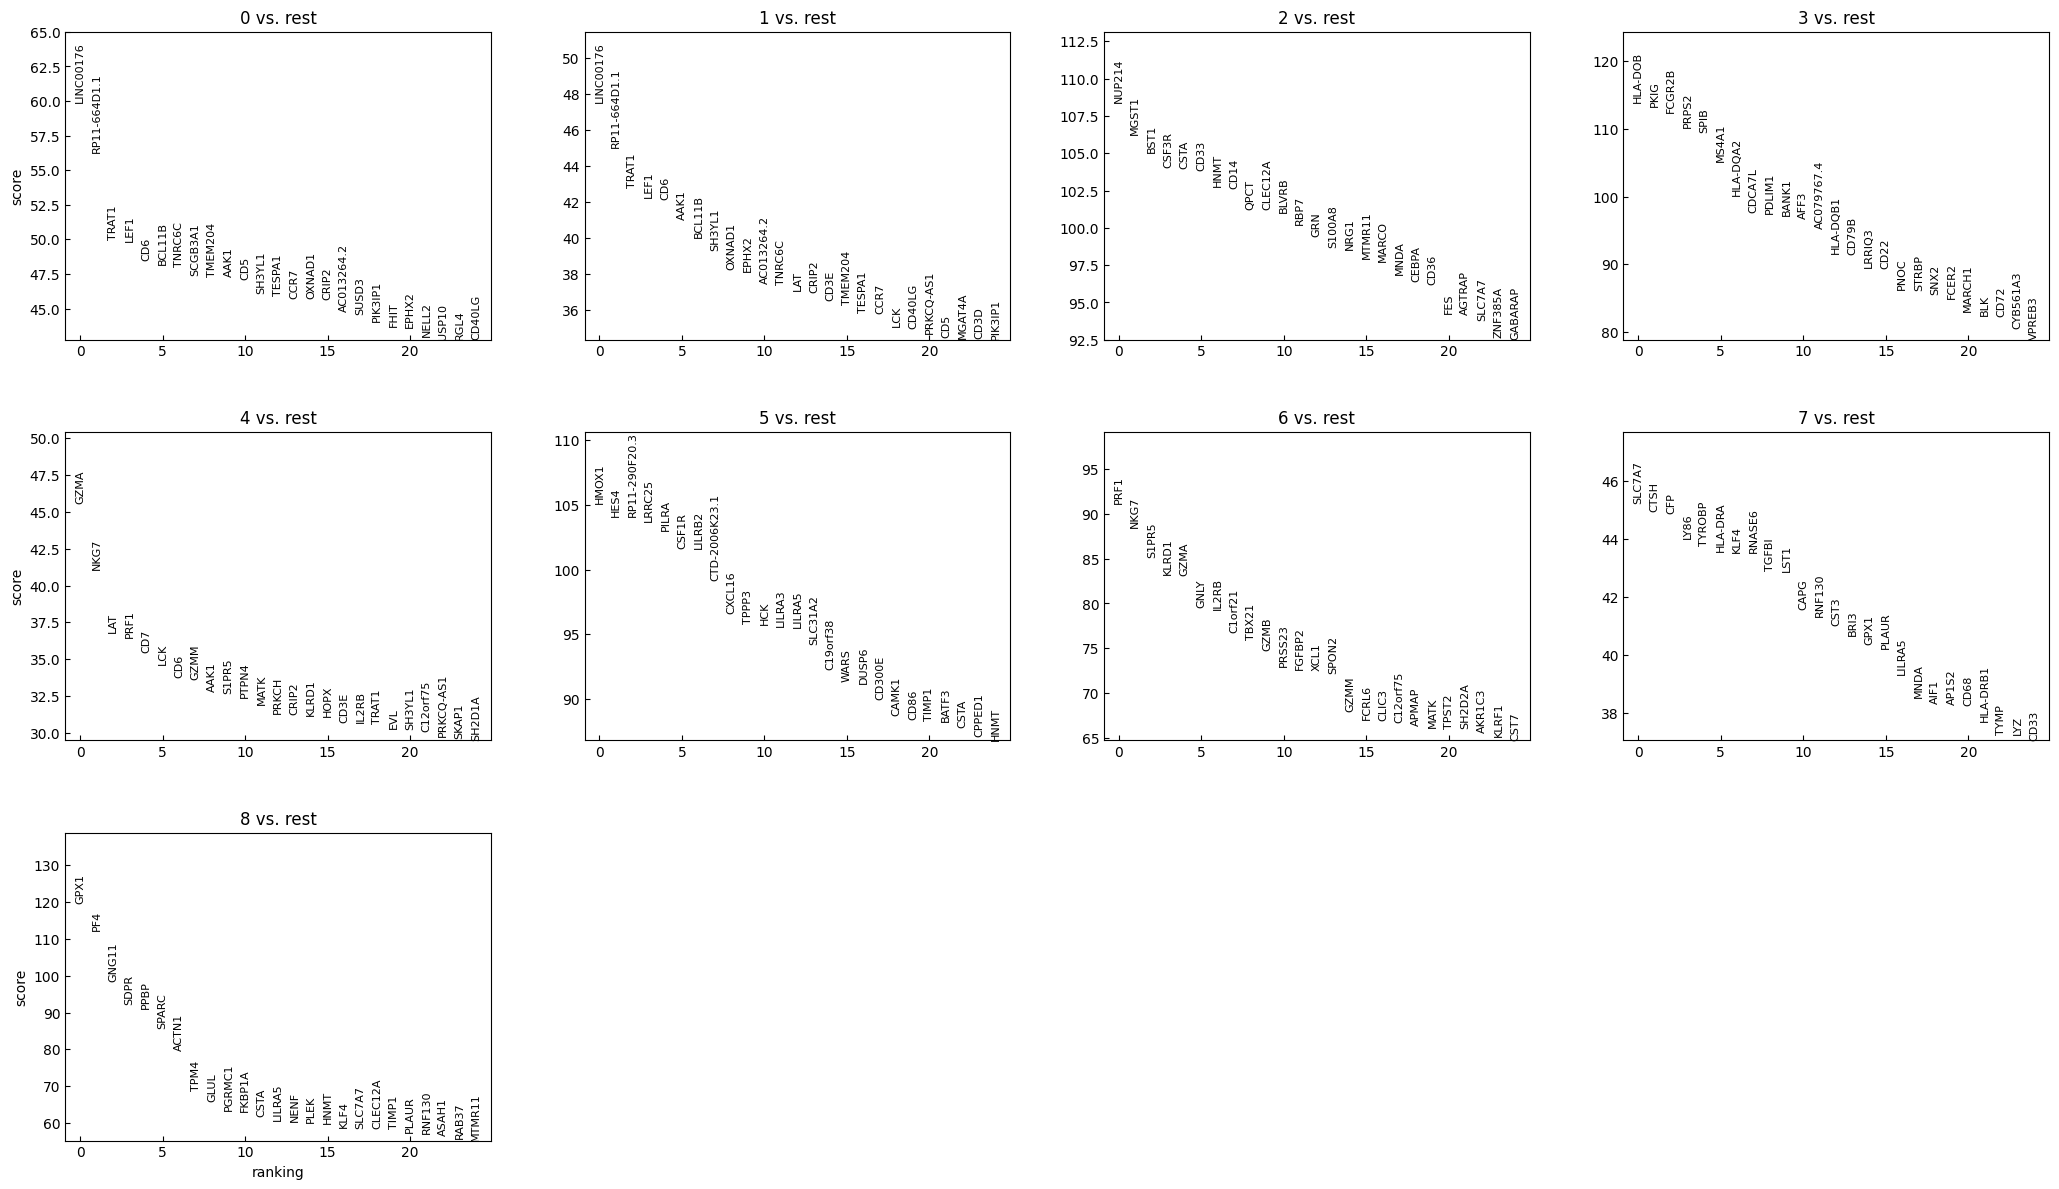

In [ ]:
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

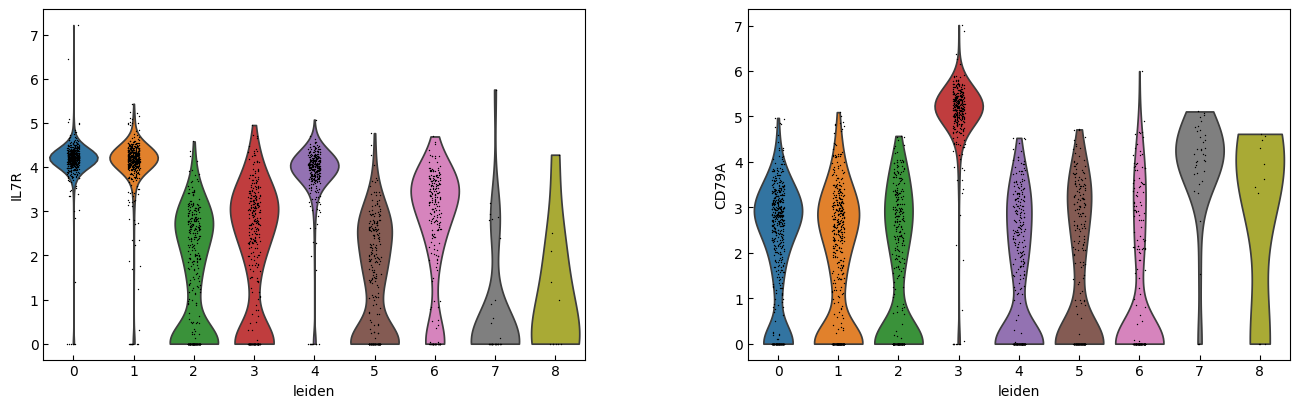

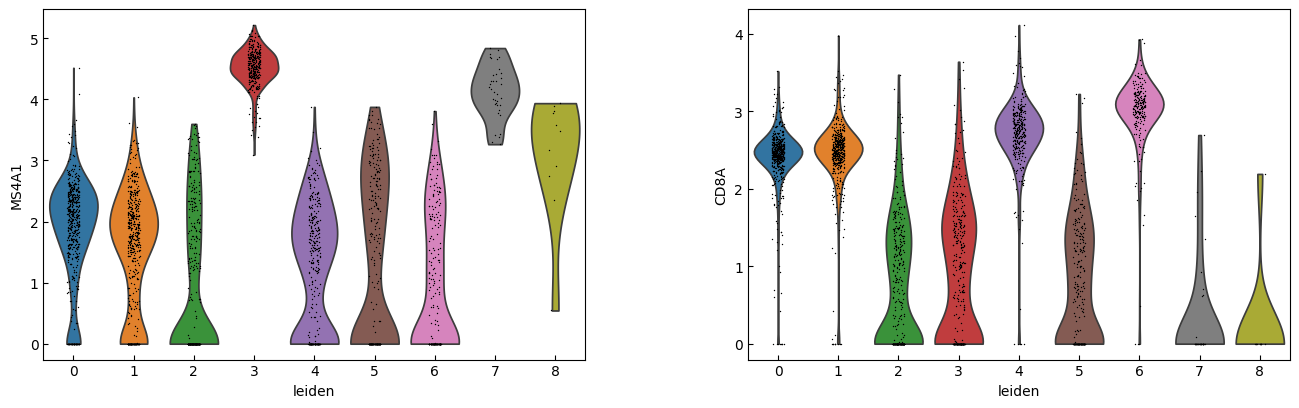

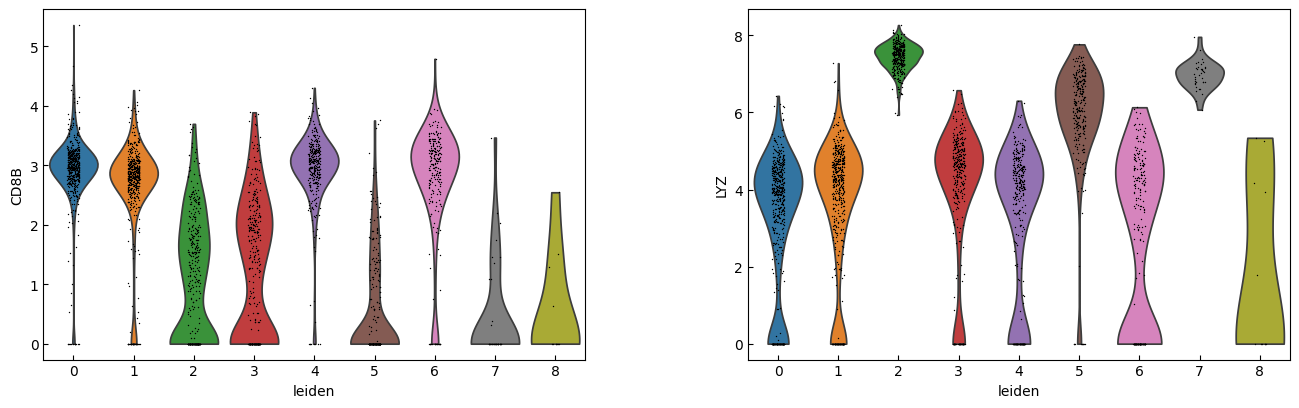

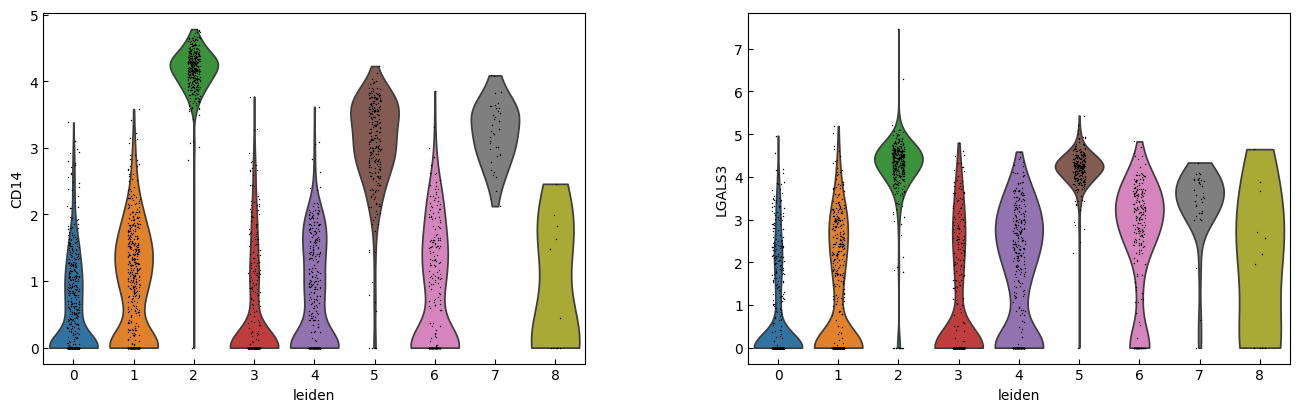

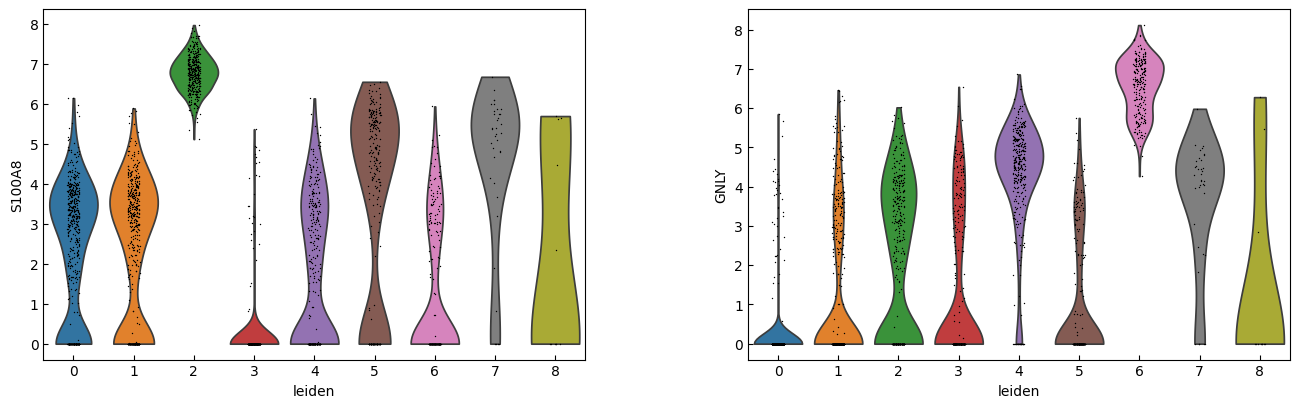

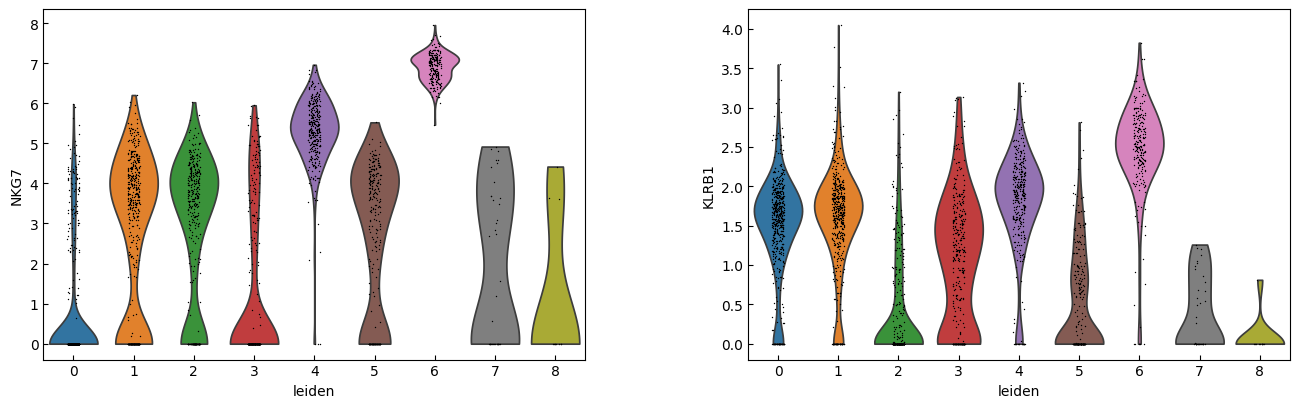

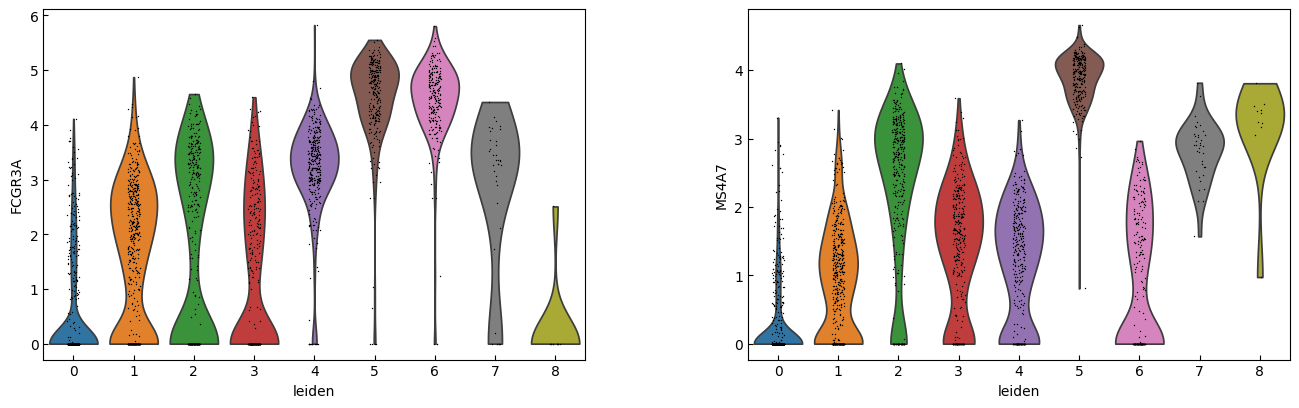

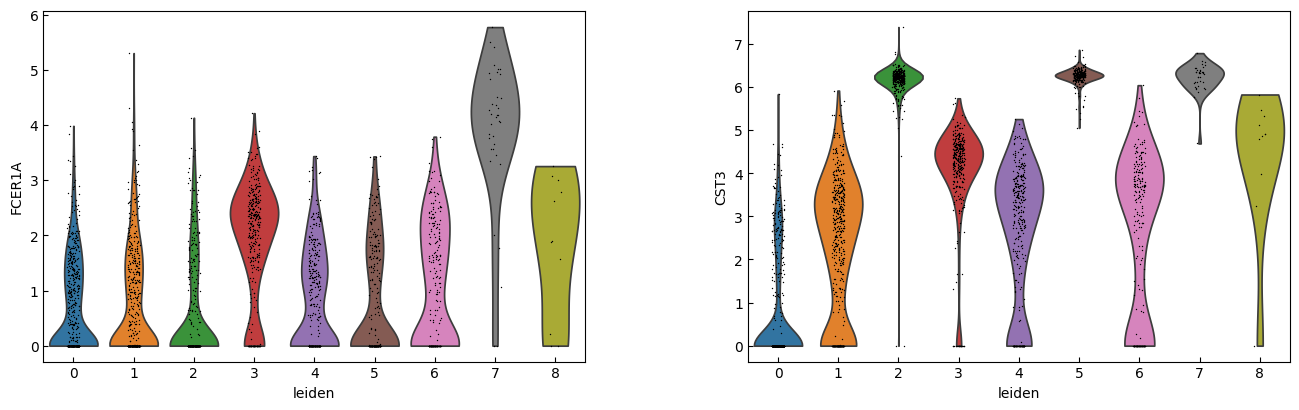

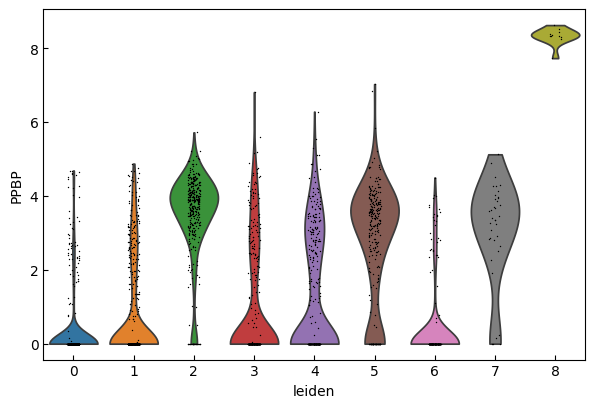

In [ ]:
adata.var_names_make_unique()
n_cols = 2
for i in range(0, len(marker_genes),n_cols):
    sc.pl.violin(adata, marker_genes[i:i+n_cols], groupby='leiden')

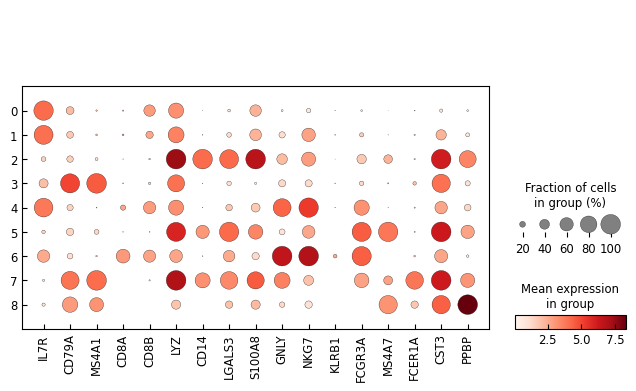

In [ ]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden",expression_cutoff=3)

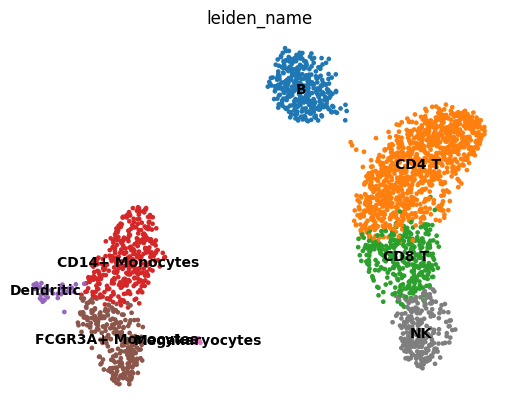

In [ ]:
cell_types = [
    "CD4 T",             # Cluster 0: high IL7R expression → CD4 T cells
    "CD4 T",             # Cluster 1: IL7R expression suggests another CD4 T cell
    "CD14+ Monocytes",   # Cluster 2: high LYZ, CD14, S100A8 → CD14+ Monocytes
    "B",                 # Cluster 3: high CD79A, MS4A1 → B cells
    "CD8 T",             # Cluster 4: high IL7R, NKG7 → CD8 T cells
    "FCGR3A+ Monocytes", # Cluster 5: expression of FCGR3A, MS4A7 (and some CD14) → FCGR3A+ monocytes
    "NK",                # Cluster 6: high GNLY, NKG7 → NK cells
    "Dendritic",         # Cluster 7: elevated FCER1A, CST3 → dendritic cells
    "Megakaryocytes",     # Cluster 8: high PPBP expression → megakaryocyte cells
]

adata.obs["leiden_name"] = [cell_types[int(i)] for i in adata.obs["leiden"].values]
if 'leiden_name_colors' in adata.uns:
    del adata.uns['leiden_name_colors']
sc.pl.umap(adata, color='leiden_name', legend_loc='on data', frameon=False)